In [1]:
import numpy as np  # this module handles arrays, but here we need it for its NaN value
import pandas as pd # this module contains a lot of tools for handling tabular data
from matplotlib import pyplot as plt
from salishsea_tools import evaltools as et
import datetime as dt
import os
import gsw
import pickle
import netCDF4 as nc
import cmocean
from scipy import stats as spst
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [2]:
modSourceDir= '/results/SalishSea/nowcast-green.201812/'
modver='201812'
Chl_N=1.8 # Chl:N ratio
fname='compHPLCModelFirstLook-Regress-Base.ipynb'
startYMD=(2015,1,1)
endYMD=(2018,12,31)

In [3]:
# Parameters
modSourceDir = "/results/SalishSea/nowcast-green.201812/"
modver = "201812"
Chl_N = 1.8
fname = "compHPLCModelFirstLook-Regress-201812.ipynb"


In [4]:
start_date = dt.datetime(startYMD[0],startYMD[1],startYMD[2])
end_date = dt.datetime(endYMD[0],endYMD[1],endYMD[2]) #dt.datetime(2019,6,30)

In [5]:
datestr='_'+start_date.strftime('%Y%m%d')+'_'+end_date.strftime('%Y%m%d')

In [6]:
def subval(idf,colList):
    # first value in colList should be the column you are going to keep
    # follow with other columns that will be used to fill in when that column is NaN
    # in order of precedence
    if len(colList)==2:
        idf[colList[0]]=[r[colList[0]] if not pd.isna(r[colList[0]]) \
                         else  r[colList[1]] for i,r in idf.iterrows()]
    elif len(colList)==3:
        idf[colList[0]]=[r[colList[0]] if not pd.isna(r[colList[0]]) \
                         else  r[colList[1]] if not pd.isna(r[colList[1]]) \
                         else r[colList[2]] for i,r in idf.iterrows()]
    else:
        raise NotImplementedError('Add to code to handle this case')
    idf.drop(columns=list(colList[1:]),inplace=True)
    return idf

In [7]:
if os.path.isfile('matched_'+modver+datestr+'.pkl'):
    data=pickle.load(open( 'matched_'+modver+datestr+'.pkl', 'rb' ) )
else:
    # define paths to the source files and eventual output file
    flist=('/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2015.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2016.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2017.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2018.csv')#,
           #'/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2019.csv')

    dfs=list()
    for fname in flist:
        idf=pd.read_csv(fname)
        print(fname,sorted(idf.keys()))
        dfs.append(idf)
    df=pd.concat(dfs,ignore_index=True,sort=False); # concatenate the list into a single table

    df.drop(labels=['ADM:MISSION','ADM:PROJECT','ADM:SCIENTIST','Zone','Zone.1','Temperature:Draw',
                    'Temperature:Draw [deg C (ITS90)]','Bottle:Firing_Sequence','Comments by sample_numbeR',
                    'File Name','LOC:EVENT_NUMBER','Number_of_bin_records'
                       ],axis=1,inplace=True)

    df=subval(df,('Dictyochophytes','Dictyo'))
    df=subval(df,('Chlorophyll:Extracted [mg/m^3]','Chlorophyll:Extracted'))
    df=subval(df,('Dinoflagellates','Dinoflagellates-1'))
    df=subval(df,('Fluorescence [mg/m^3]','Fluorescence:URU:Seapoint [mg/m^3]','Fluorescence:URU:Seapoint'))
    df=subval(df,('Lat','LOC:LATITUDE'))
    df=subval(df,('Lon','LOC:LONGITUDE'))
    df=subval(df,('Nitrate_plus_Nitrite [umol/L]','Nitrate_plus_Nitrite'))
    df=subval(df,('PAR [uE/m^2/sec]','PAR'))
    df=subval(df,('Phaeo-Pigment:Extracted [mg/m^3]','Phaeo-Pigment:Extracted'))
    df=subval(df,('Phosphate [umol/L]','Phosphate'))
    df=subval(df,('Pressure [decibar]','Pressure'))
    df=subval(df,('Raphidophytes','Raphido'))
    df=subval(df,('Salinity','Salinity [PSS-78]','Salinity:T1:C1 [PSS-78]'))
    df=subval(df,('Salinity:Bottle','Salinity:Bottle [PSS-78]'))
    df=subval(df,('Silicate [umol/L]','Silicate'))
    df=subval(df,('TchlA (ug/L)','TchlA'))
    df=subval(df,('Temperature','Temperature [deg C (ITS90)]','Temperature:Secondary [deg C (ITS90)]'))
    df=subval(df,('Transmissivity [*/metre]','Transmissivity'))

    df['Z']=np.where(pd.isna(df['Depth [metres]']),
                     -1*gsw.z_from_p(df['Pressure [decibar]'],df['Lat']),
                     df['Depth [metres]'])
    df['p']=np.where(pd.isna(df['Pressure [decibar]']),
                     gsw.p_from_z(-1*df['Depth [metres]'],df['Lat']),
                    df['Pressure [decibar]'])
    df['SA']=gsw.SA_from_SP(df['Salinity'],df['p'],df['Lon'],df['Lat'])
    df['CT']=gsw.CT_from_t(df['SA'],df['Temperature'],df['p'])

    df['dtUTC']=[dt.datetime.strptime(ii,'%Y-%m-%d %H:%M:%S') if isinstance(ii,str) else np.nan for ii in df['FIL:START TIME YYYY/MM/DD HH:MM:SS'] ]

    PATH= modSourceDir

    flen=1
    namfmt='nowcast'
    #varmap={'N':'nitrate','Si':'silicon','Ammonium':'ammonium'}
    filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}
    #gridmap={'nitrate':'tmask','silicon':'tmask','ammonium':'tmask'}
    fdict={'ptrc_T':1,'grid_T':1}

    data=et.matchData(df,filemap,fdict,start_date,end_date,namfmt,PATH,flen)

    with open('matched_'+modver+datestr+'.pkl','wb') as f:
        pickle.dump(data,f)

In [8]:
print(len(data))
iii=(data.Cruise=='2015-20')|(data.Cruise=='2015-21')
ind=data.loc[iii].index
data.drop(ind,inplace=True)
print(len(data))

5607
5566


In [9]:
~iii[0]

True

In [10]:
data['other']=0.0
for el in ('Cryptophytes', 'Cyanobacteria', 'Dictyochophytes', 'Dinoflagellates',
    'Haptophytes', 'Prasinophytes', 'Raphidophytes'):
    data['other']=data['other']+data[el]

(0, 8)

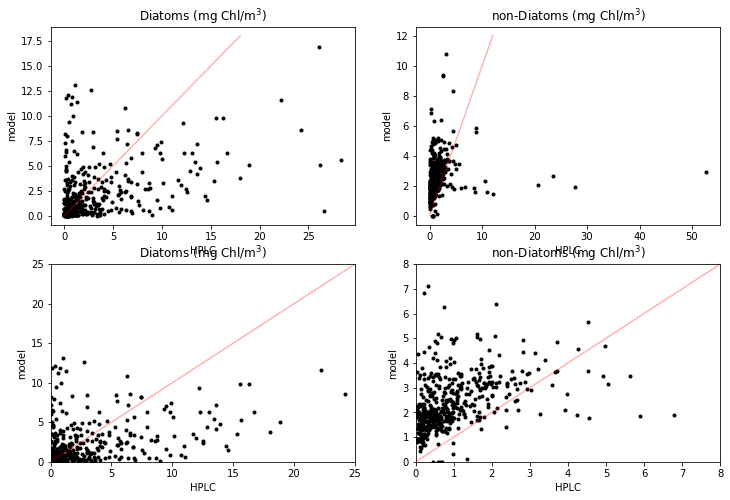

In [11]:
fig,ax=plt.subplots(2,2,figsize=(12,8))
ax=ax.flatten()
ax[0].plot(data['Diatoms-1']+data['Diatoms-2'],Chl_N*data['mod_diatoms'],'k.')
ax[0].set_title('Diatoms (mg Chl/m$^3$)')
ax[0].set_xlabel('HPLC')
ax[0].set_ylabel('model')
ax[0].plot((0,18),(0,18),'r-',alpha=.3)

ax[1].plot(data['other'],Chl_N*(data['mod_flagellates']+data['mod_ciliates']),'k.')
ax[1].set_title('non-Diatoms (mg Chl/m$^3$)')
ax[1].set_xlabel('HPLC')
ax[1].set_ylabel('model')
ax[1].plot((0,12),(0,12),'r-',alpha=.3)

ax[2].plot(data['Diatoms-1']+data['Diatoms-2'],Chl_N*data['mod_diatoms'],'k.')
ax[2].set_title('Diatoms (mg Chl/m$^3$)')
ax[2].set_xlabel('HPLC')
ax[2].set_ylabel('model')
ax[2].plot((0,25),(0,25),'r-',alpha=.3)
ax[2].set_xlim((0,25))
ax[2].set_ylim((0,25))

ax[3].plot(data['other'],Chl_N*(data['mod_flagellates']+data['mod_ciliates']),'k.')
ax[3].set_title('non-Diatoms (mg Chl/m$^3$)')
ax[3].set_xlabel('HPLC')
ax[3].set_ylabel('model')
ax[3].plot((0,12),(0,12),'r-',alpha=.3)
ax[3].set_xlim((0,8))
ax[3].set_ylim((0,8))

In [12]:
def logt(x):
    return np.log10(x+.001)

(-3.1, 2)

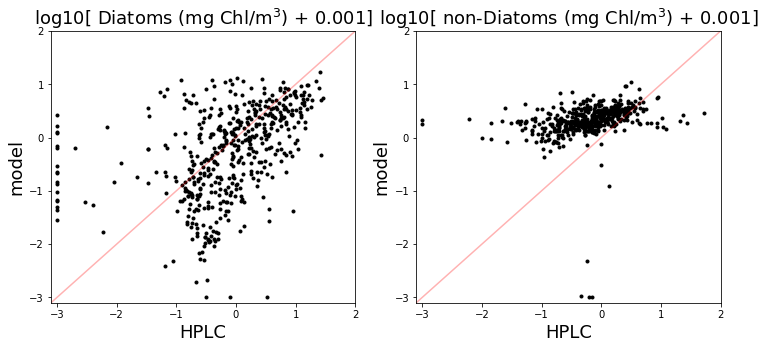

In [13]:
fig,ax=plt.subplots(1,2,figsize=(12,5))
ax[0].plot(logt(data['Diatoms-1']+data['Diatoms-2']),logt(Chl_N*data['mod_diatoms']),'k.')
ax[0].set_title('log10[ Diatoms (mg Chl/m$^3$) + 0.001]',fontsize=18)
ax[0].set_xlabel('HPLC',fontsize=18)
ax[0].set_ylabel('model',fontsize=18)
ax[0].set_xlim(-3.1,2)
ax[0].set_ylim(-3.1,2)
ax[0].plot((-6,3),(-6,3),'r-',alpha=.3)

ax[1].plot(logt(data['other']),logt(Chl_N*(data['mod_flagellates']+data['mod_ciliates'])),'k.')
ax[1].set_title('log10[ non-Diatoms (mg Chl/m$^3$) + 0.001]',fontsize=18)
ax[1].set_xlabel('HPLC',fontsize=18)
ax[1].set_ylabel('model',fontsize=18)
ax[1].plot((-6,3),(-6,3),'r-',alpha=.3)
ax[1].set_xlim(-3.1,2)
ax[1].set_ylim(-3.1,2)

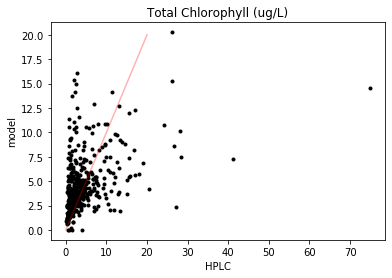

In [14]:
plt.plot(data['TchlA (ug/L)'],Chl_N*(data['mod_flagellates']+data['mod_ciliates']+data['mod_diatoms']),'k.')
plt.title('Total Chlorophyll (ug/L)')
plt.xlabel('HPLC')
plt.ylabel('model')
plt.plot((0,20),(0,20),'r-',alpha=.3)

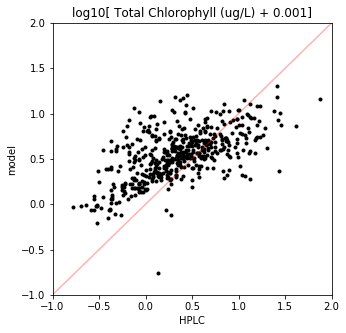

In [15]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(logt(data['TchlA (ug/L)']),logt(Chl_N*(data['mod_flagellates']+data['mod_ciliates']+data['mod_diatoms'])),'k.')
ax.set_title('log10[ Total Chlorophyll (ug/L) + 0.001]')
ax.set_xlabel('HPLC')
ax.set_ylabel('model')
ax.plot((-6,5),(-6,5),'r-',alpha=.3)
ax.set_xlim(-1,2)
ax.set_ylim(-1,2);

In [16]:
def yd(idt):
    if type(idt)==dt.datetime:
        yd=(idt-dt.datetime(idt.year-1,12,31)).days
    else: # assume array or pandas
        yd=[(ii-dt.datetime(ii.year-1,12,31)).days for ii in idt]
    return yd

data['yd']=yd(data['dtUTC'])
data['Year']=[ii.year for ii in data['dtUTC']]

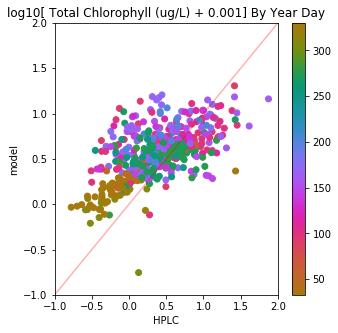

In [17]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
m=ax.scatter(logt(data['TchlA (ug/L)']),logt(Chl_N*(data['mod_flagellates']+data['mod_ciliates']+data['mod_diatoms'])),
          c=data['yd'],cmap=cmocean.cm.phase)
ax.set_title('log10[ Total Chlorophyll (ug/L) + 0.001] By Year Day')
ax.set_xlabel('HPLC')
ax.set_ylabel('model')
ax.plot((-6,5),(-6,5),'r-',alpha=.3)
ax.set_xlim(-1,2)
ax.set_ylim(-1,2);
fig.colorbar(m)

In [18]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])

## Multiple Linear Regression

#### Diatoms

In [19]:
ii=(~pd.isnull(data['mod_diatoms']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Diatoms-2']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Dinoflagellates']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Diatoms-2'],data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],data.loc[ii]['Dinoflagellates'],
             data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_diatoms']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [20]:
m

array([ 0.14548401,  0.02147617, -2.54544623,  1.55488573, -0.82680015,
       -0.04815549, -0.25186822, -0.1641013 ,  0.14493949,  0.56324667])

In [21]:
clist=('Diatoms-1','Diatoms-2','Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','Dinoflagellates','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.1454840092913046
Diatoms-2 0.021476165529797364
Cyanobacteria -2.5454462313384765
Cryptophytes 1.5548857282966826
Prasinophytes -0.8268001489586629
Haptophytes -0.04815548701436267
Dictyochophytes -0.25186821934430853
Dinoflagellates -0.16410130221308075
Raphidophytes 0.1449394938361368
ones 0.5632466702895635


In [22]:
ii=(~pd.isnull(data['mod_diatoms']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Diatoms-2']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Diatoms-2'],data.loc[ii]['Cryptophytes'],
            data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_diatoms']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [23]:
clist=('Diatoms-1','Diatoms-2','Cryptophytes','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.15526343414018084
Diatoms-2 -0.025000305639848563
Cryptophytes 0.46180867335051845
Raphidophytes 0.09150216617109772
ones 0.5086798337773485


In [24]:
ii=(~pd.isnull(data['mod_diatoms']))&(~pd.isnull(data['Diatoms-1']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Cryptophytes'],
            data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_diatoms']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [25]:
clist=('Diatoms-1','Cryptophytes','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.1550653284755521
Cryptophytes 0.45717517218167036
Raphidophytes 0.09050900418538965
ones 0.5044234218639336


#### flagellates

In [26]:
ii=(~pd.isnull(data['mod_flagellates']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Diatoms-2']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Dinoflagellates']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Diatoms-2'],data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],data.loc[ii]['Dinoflagellates'],
             data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_flagellates']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [27]:
m

array([ 0.01171609, -0.07822761,  1.82474716,  0.56828646,  0.1872075 ,
        0.26130933,  0.13729326,  0.09112575, -0.04320779,  0.66416823])

In [28]:
clist=('Diatoms-1','Diatoms-2','Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','Dinoflagellates','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.011716089853456329
Diatoms-2 -0.07822761022817015
Cyanobacteria 1.8247471567203748
Cryptophytes 0.5682864640529355
Prasinophytes 0.18720750115349047
Haptophytes 0.2613093253709624
Dictyochophytes 0.13729325998160177
Dinoflagellates 0.09112575252425403
Raphidophytes -0.043207794126351506
ones 0.6641682254192771


In [29]:
ii=(~pd.isnull(data['mod_flagellates']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Dinoflagellates']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],
             data.loc[ii]['Dinoflagellates'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_flagellates']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [30]:
clist=('Diatoms-1','Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','Dinoflagellates','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.0052853655248482415
Cyanobacteria 1.0097477371005446
Cryptophytes 0.6229161670856558
Prasinophytes 0.2034617626130143
Haptophytes 0.28533334890453366
Dictyochophytes 0.05791687914074261
Dinoflagellates 0.01134379345329295
ones 0.6616408922307975


In [31]:
ii=(~pd.isnull(data['mod_flagellates']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],
             np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_flagellates']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [32]:
clist=('Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Cyanobacteria 1.0491059654481276
Cryptophytes 0.6125033398091253
Prasinophytes 0.19108363709220122
Haptophytes 0.28315549628688585
Dictyochophytes 0.05394907850368103
ones 0.68008440037787


#### M. rubrum

In [33]:
ii=(~pd.isnull(data['mod_ciliates']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Diatoms-2']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Dinoflagellates']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Diatoms-2'],data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],data.loc[ii]['Dinoflagellates'],
             data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_ciliates']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [34]:
clist=('Diatoms-1','Diatoms-2','Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','Dinoflagellates','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.014468256092533096
Diatoms-2 0.011698114566876916
Cyanobacteria 0.3081431179161839
Cryptophytes 0.008088650772307667
Prasinophytes -0.00015692210923901918
Haptophytes 0.040363429540893996
Dictyochophytes -0.04281524447146262
Dinoflagellates 0.03653302535228498
Raphidophytes -0.007918707429542399
ones 0.2968506894357214


Diatoms:
- Cryptophytes 0.38
- Diatoms-1 0.16
- Raphidophytes 0.09

Flagellates:
- Cyanobacteria 0.9248939785743201
- Cryptophytes 0.592769155988474
- Prasinophytes 0.18975008147644779
- Haptophytes 0.2794204846195845
- Dictyochophytes 0.058845777018170356

M. rubrum:
- Cyanobacteria 0.2710109702166438

None:
- Diatoms-2
- Dinoflagellates

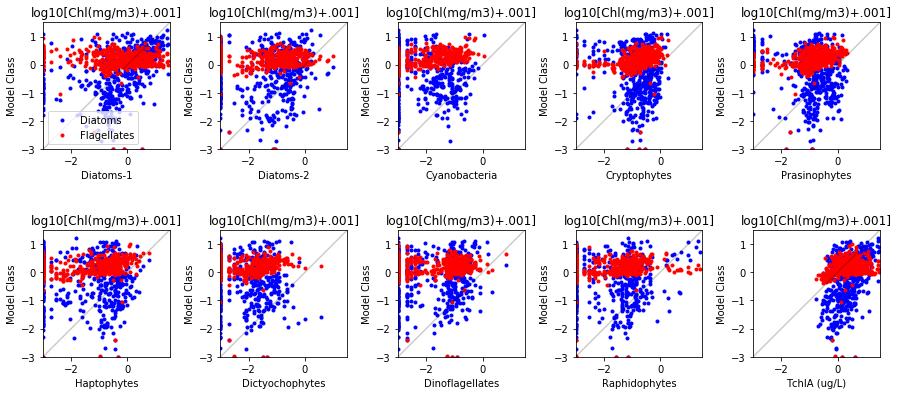

In [35]:
fig,ax=plt.subplots(2,5,figsize=(15,7))
fig.subplots_adjust(wspace=.4)
ax=ax.flatten()

chplc=('Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
       'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','TchlA (ug/L)')

mvar1=Chl_N*data['mod_diatoms']
mvar2=Chl_N*data['mod_flagellates']

for ii in range(0,len(chplc)):
    ax[ii].plot(logt(data.loc[:,[chplc[ii]]].values),logt(mvar1),'.',color='blue',label='Diatoms')
    ax[ii].plot(logt(data.loc[:,[chplc[ii]]].values),logt(mvar2),'.',color='red',label='Flagellates')
    ax[ii].set_ylabel('Model Class')
    ax[ii].set_xlabel(chplc[ii])
    ax[ii].set_title('log10[Chl(mg/m3)+.001]')
    ax[ii].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
    ax[ii].set_xlim((-3,1.5))
    ax[ii].set_ylim((-3,1.5))
    ax[ii].set_aspect(1)
ax[0].legend()


(-3, 1.5)

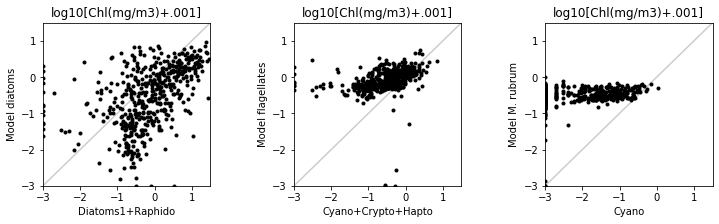

In [36]:
fig,ax=plt.subplots(1,3,figsize=(12,3))
fig.subplots_adjust(wspace=.5)
#ax[0].plot(logt(data['Diatoms-1']+data['Raphidophytes']+.5*data['Cryptophytes']),logt(data['mod_diatoms']),'r.')
ax[0].plot(logt(data['Diatoms-1']+data['Raphidophytes']),logt(data['mod_diatoms']),'k.')
ax[0].set_ylabel('Model diatoms')
ax[0].set_xlabel('Diatoms1+Raphido')
ax[0].set_title('log10[Chl(mg/m3)+.001]')
ax[0].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
ax[0].set_xlim((-3,1.5))
ax[0].set_ylim((-3,1.5))

ax[1].plot(logt(data['Cyanobacteria']+data['Cryptophytes']+data['Haptophytes']),logt(data['mod_flagellates']),'k.')
ax[1].set_ylabel('Model flagellates')
ax[1].set_xlabel('Cyano+Crypto+Hapto')
ax[1].set_title('log10[Chl(mg/m3)+.001]')
ax[1].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
ax[1].set_xlim((-3,1.5))
ax[1].set_ylim((-3,1.5))


ax[2].plot(logt(data['Cyanobacteria']),logt(data['mod_ciliates']),'k.')
ax[2].set_ylabel('Model M. rubrum')
ax[2].set_xlabel('Cyano')
ax[2].set_title('log10[Chl(mg/m3)+.001]')
ax[2].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
ax[2].set_xlim((-3,1.5))
ax[2].set_ylim((-3,1.5))

In [37]:
data['mod_diatoms_chl']=Chl_N*data['mod_diatoms']
data['mod_flagellates_chl']=Chl_N*data['mod_flagellates']
data['mod_ciliates_chl']=Chl_N*data['mod_ciliates']
data['mod_TChl']=data['mod_diatoms_chl']+data['mod_flagellates_chl']+data['mod_ciliates_chl']
data['CCPH']=data['Cyanobacteria']+data['Cryptophytes']+data['Prasinophytes']+data['Haptophytes']
data['DD']=data['Diatoms-1']+data['Diatoms-2']
dfVars=data.loc[:,['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
       'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','DD','CCPH','TchlA (ug/L)',
                   'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']]

### Variance-Covariance Matrix

In [38]:
dfVars.cov()

,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,17.595529,0.193973,-0.022377,-0.217876,-0.256572,-0.192596,-0.037842,0.093690,2.426976,17.789501,-0.689421,19.573237,5.133755,-0.314213,0.407744,5.227287
Diatoms-2,0.193973,0.471600,0.010478,0.014152,0.021230,0.025039,0.027436,0.017806,0.368075,0.665573,0.070899,1.150877,0.106003,-0.013327,0.016696,0.109373
Cyanobacteria,-0.022377,0.010478,0.008802,0.012657,0.019907,0.011128,0.001686,0.004862,0.126132,-0.011899,0.052495,0.172865,-0.010232,0.043353,0.003909,0.037030
Cryptophytes,-0.217876,0.014152,0.012657,0.067707,0.052853,0.044074,0.002174,0.016648,0.085387,-0.203724,0.177291,0.075761,0.008666,0.139646,0.005522,0.153835
Prasinophytes,-0.256572,0.021230,0.019907,0.052853,0.110838,0.039941,0.006361,0.008998,0.196495,-0.235342,0.223539,0.197842,-0.132373,0.155317,0.005776,0.028719
Haptophytes,-0.192596,0.025039,0.011128,0.044074,0.039941,0.216512,0.001436,0.002943,-0.047281,-0.167557,0.311655,0.098871,-0.069963,0.194122,0.018796,0.142955
Dictyochophytes,-0.037842,0.027436,0.001686,0.002174,0.006361,0.001436,0.032001,0.002984,0.034882,-0.010407,0.011657,0.070917,-0.026339,0.011646,-0.002104,-0.016796
Dinoflagellates,0.093690,0.017806,0.004862,0.016648,0.008998,0.002943,0.002984,0.118736,0.272063,0.111496,0.033451,0.538659,0.070572,0.036006,0.009684,0.116261
Raphidophytes,2.426976,0.368075,0.126132,0.085387,0.196495,-0.047281,0.034882,0.272063,8.383431,2.795051,0.360733,11.841951,2.117719,-0.053936,0.034440,2.098223
DD,17.789501,0.665573,-0.011899,-0.203724,-0.235342,-0.167557,-0.010407,0.111496,2.795051,18.455074,-0.618522,20.724114,5.239759,-0.327540,0.424440,5.336659


### Correlation Coefficient Matrix

In [39]:
dfVars.corr()

,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,1.000000,0.067337,-0.056860,-0.199614,-0.183723,-0.098674,-0.050430,0.064819,0.199827,0.987199,-0.187914,0.803182,0.465471,-0.063767,0.390610,0.427462
Diatoms-2,0.067337,1.000000,0.162623,0.079199,0.092858,0.078358,0.223329,0.075246,0.185114,0.225606,0.118039,0.288466,0.058694,-0.016516,0.097675,0.054619
Cyanobacteria,-0.056860,0.162623,1.000000,0.518467,0.637346,0.254907,0.100483,0.150385,0.464322,-0.029524,0.639728,0.317149,-0.041465,0.393231,0.167386,0.135343
Cryptophytes,-0.199614,0.079199,0.518467,1.000000,0.610109,0.364019,0.046700,0.185671,0.113334,-0.182249,0.779013,0.050117,0.012664,0.456768,0.085269,0.202756
Prasinophytes,-0.183723,0.092858,0.637346,0.610109,1.000000,0.257828,0.106802,0.078438,0.203843,-0.164550,0.767687,0.102288,-0.151183,0.397037,0.069695,0.029583
Haptophytes,-0.098674,0.078358,0.254907,0.364019,0.257828,1.000000,0.017246,0.018354,-0.035094,-0.083823,0.765787,0.036575,-0.057186,0.355144,0.162328,0.105386
Dictyochophytes,-0.050430,0.223329,0.100483,0.046700,0.106802,0.017246,1.000000,0.048415,0.067346,-0.013542,0.074501,0.068237,-0.055980,0.055403,-0.047248,-0.032197
Dinoflagellates,0.064819,0.075246,0.150385,0.185671,0.078438,0.018354,0.048415,1.000000,0.272688,0.075320,0.110991,0.269076,0.077865,0.088920,0.112889,0.115694
Raphidophytes,0.199827,0.185114,0.464322,0.113334,0.203843,-0.035094,0.067346,0.272688,1.000000,0.224709,0.142446,0.703987,0.278074,-0.015852,0.047781,0.248489
DD,0.987199,0.225606,-0.029524,-0.182249,-0.164550,-0.083823,-0.013542,0.075320,0.224709,1.000000,-0.164616,0.830367,0.463848,-0.064899,0.396989,0.426086


### Cov matrix with log transformed values:

In [40]:
dflog=pd.DataFrame()
for el in ['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
       'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','CCPH','TchlA (ug/L)',
                   'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']:
    dflog[el]=logt(data[el])
dflog.cov()

,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,1.168135,0.063032,-0.357141,-0.211428,-0.330776,-0.354541,-0.119628,0.168847,-0.110058,-0.222465,0.266414,0.354599,-0.043011,0.045890,0.079697
Diatoms-2,0.063032,1.258458,0.022219,0.034740,0.049129,0.088057,0.324390,0.242943,0.070797,0.017536,0.081377,0.083136,0.004337,0.020915,0.023825
Cyanobacteria,-0.357141,0.022219,0.770740,0.276611,0.431289,0.351627,0.258563,0.123557,0.389066,0.296917,0.041171,-0.135799,0.141612,0.041498,0.042891
Cryptophytes,-0.211428,0.034740,0.276611,0.463058,0.418259,0.194907,0.186897,0.228121,0.308840,0.293429,0.007611,-0.090269,0.059639,-0.010337,-0.000033
Prasinophytes,-0.330776,0.049129,0.431289,0.418259,0.816950,0.233981,0.276029,0.183202,0.455337,0.364976,-0.014573,-0.248232,0.095083,-0.010058,-0.025242
Haptophytes,-0.354541,0.088057,0.351627,0.194907,0.233981,1.193535,0.172277,0.093258,0.172081,0.385794,0.053356,-0.027006,0.092715,0.033549,0.042464
Dictyochophytes,-0.119628,0.324390,0.258563,0.186897,0.276029,0.172277,0.597276,0.215538,0.257005,0.161284,0.028992,-0.074880,0.043718,-0.007007,-0.003337
Dinoflagellates,0.168847,0.242943,0.123557,0.228121,0.183202,0.093258,0.215538,0.981469,0.400832,0.153376,0.159107,0.138884,0.020519,0.008358,0.030477
Raphidophytes,-0.110058,0.070797,0.389066,0.308840,0.455337,0.172081,0.257005,0.400832,1.121045,0.268117,0.088742,-0.026473,0.069169,0.013253,0.035051
CCPH,-0.222465,0.017536,0.296917,0.293429,0.364976,0.385794,0.161284,0.153376,0.268117,0.330449,0.028604,-0.062636,0.064655,0.008341,0.016461


### Corr Coeff matrix with log transformed values:

In [41]:
dflog.corr()

,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,1.000000,0.051987,-0.376391,-0.287474,-0.338602,-0.300263,-0.143219,0.157692,-0.096175,-0.358065,0.542124,0.384936,-0.108038,0.138465,0.178999
Diatoms-2,0.051987,1.000000,0.022561,0.045508,0.048453,0.071850,0.374163,0.218598,0.059605,0.027193,0.159539,0.087022,0.010504,0.060851,0.051597
Cyanobacteria,-0.376391,0.022561,1.000000,0.463018,0.543522,0.366616,0.381088,0.142061,0.418561,0.588340,0.103139,-0.181401,0.437716,0.154079,0.118540
Cryptophytes,-0.287474,0.045508,0.463018,1.000000,0.680032,0.262176,0.355383,0.338384,0.428652,0.750123,0.024598,-0.155555,0.237808,-0.049511,-0.000118
Prasinophytes,-0.338602,0.048453,0.543522,0.680032,1.000000,0.236955,0.395158,0.204595,0.475799,0.702449,-0.035460,-0.321940,0.285345,-0.036259,-0.067733
Haptophytes,-0.300263,0.071850,0.366616,0.262176,0.236955,1.000000,0.204043,0.086164,0.148766,0.614307,0.107411,-0.029004,0.230411,0.100151,0.094360
Dictyochophytes,-0.143219,0.374163,0.381088,0.355383,0.395158,0.204043,1.000000,0.281513,0.314082,0.363037,0.082505,-0.113717,0.153629,-0.029577,-0.010485
Dinoflagellates,0.157692,0.218598,0.142061,0.338384,0.204595,0.086164,0.281513,1.000000,0.382131,0.269319,0.353213,0.164437,0.056215,0.027506,0.074658
Raphidophytes,-0.096175,0.059605,0.418561,0.428652,0.475799,0.148766,0.314082,0.382131,1.000000,0.440515,0.184334,-0.029367,0.177548,0.040865,0.080447
CCPH,-0.358065,0.027193,0.588340,0.750123,0.702449,0.614307,0.363037,0.269319,0.440515,1.000000,0.109437,-0.127774,0.305194,0.047295,0.069475


### New groups Model-Obs Comparison:

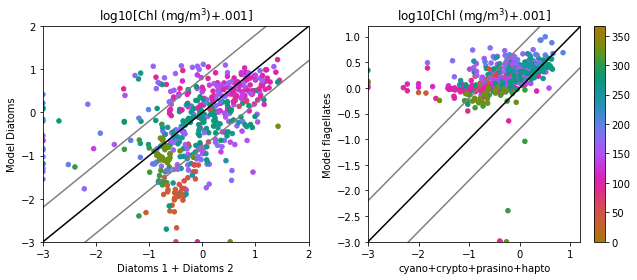

In [42]:
thresh=.8
msize=20
fig,ax=plt.subplots(1,2,figsize=(9,4))
m=ax[0].scatter(logt(data['DD']),logt(data['mod_diatoms_chl']),
          c=data['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
m=ax[1].scatter(logt(data['CCPH']),logt(data['mod_flagellates_chl']),
          c=data['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0].set_xlim(-3,2)
ax[0].set_ylim(-3,2)
ax[1].set_xlim(-3,1.2)
ax[1].set_ylim(-3,1.2)
ax[0].set_xlabel('Diatoms 1 + Diatoms 2')
ax[0].set_ylabel('Model Diatoms')
ax[0].set_title('log10[Chl (mg/m$^3$)+.001]')
ax[1].set_xlabel('cyano+crypto+prasino+hapto')
ax[1].set_ylabel('Model flagellates')
ax[1].set_title('log10[Chl (mg/m$^3$)+.001]')
ax[0].plot((-3,2),(-3+thresh,2+thresh),'-',color='grey')
ax[0].plot((-3,2),(-3-thresh,2-thresh),'-',color='grey')
ax[1].plot((-3,2),(-3+thresh,2+thresh),'-',color='grey')
ax[1].plot((-3,2),(-3-thresh,2-thresh),'-',color='grey')
ax[0].plot((-3,2),(-3,2),'k-')
ax[1].plot((-3,1.2),(-3,1.2),'k-')
plt.tight_layout()
fig.colorbar(m,ax=ax[1])

### Nina says Do not include cyanos- they are not flagellates and their abundance is low

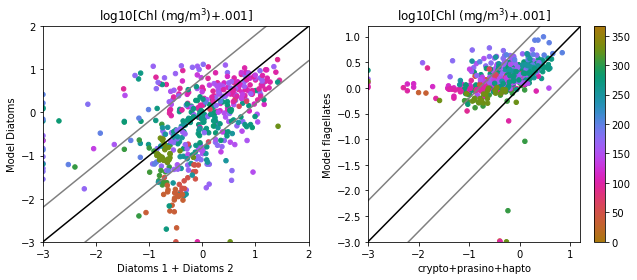

In [43]:
thresh=.8
msize=20
fig,ax=plt.subplots(1,2,figsize=(9,4))
m=ax[0].scatter(logt(data['DD']),logt(data['mod_diatoms_chl']),
          c=data['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
m=ax[1].scatter(logt(data['CCPH']-data['Cyanobacteria']),logt(data['mod_flagellates_chl']),
          c=data['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0].set_xlim(-3,2)
ax[0].set_ylim(-3,2)
ax[1].set_xlim(-3,1.2)
ax[1].set_ylim(-3,1.2)
ax[0].set_xlabel('Diatoms 1 + Diatoms 2')
ax[0].set_ylabel('Model Diatoms')
ax[0].set_title('log10[Chl (mg/m$^3$)+.001]')
ax[1].set_xlabel('crypto+prasino+hapto')
ax[1].set_ylabel('Model flagellates')
ax[1].set_title('log10[Chl (mg/m$^3$)+.001]')
ax[0].plot((-3,2),(-3+thresh,2+thresh),'-',color='grey')
ax[0].plot((-3,2),(-3-thresh,2-thresh),'-',color='grey')
ax[1].plot((-3,2),(-3+thresh,2+thresh),'-',color='grey')
ax[1].plot((-3,2),(-3-thresh,2-thresh),'-',color='grey')
ax[0].plot((-3,2),(-3,2),'k-')
ax[1].plot((-3,1.2),(-3,1.2),'k-')
plt.tight_layout()
fig.colorbar(m,ax=ax[1])

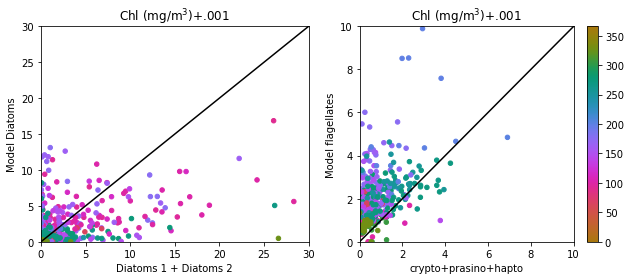

In [44]:
thresh=.8
msize=20
fig,ax=plt.subplots(1,2,figsize=(9,4))
m=ax[0].scatter(data['DD'],data['mod_diatoms_chl'],
          c=data['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
m=ax[1].scatter(data['CCPH']-data['Cyanobacteria'],data['mod_flagellates_chl'],
          c=data['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0].set_xlim(0,30)
ax[0].set_ylim(0,30)
ax[1].set_xlim(0,10)
ax[1].set_ylim(0,10)
ax[0].set_xlabel('Diatoms 1 + Diatoms 2')
ax[0].set_ylabel('Model Diatoms')
ax[0].set_title('Chl (mg/m$^3$)+.001')
ax[1].set_xlabel('crypto+prasino+hapto')
ax[1].set_ylabel('Model flagellates')
ax[1].set_title('Chl (mg/m$^3$)+.001')
ax[0].plot((0,30),(0,30),'k-')
ax[1].plot((0,10),(0,10),'k-')
plt.tight_layout()
fig.colorbar(m,ax=ax[1])

In [47]:
ii=(data['DD']>=0)&(data['mod_diatoms_chl']>=0)
slope, intercept, r_value, p_value, std_err = spst.linregress(data.loc[ii]['DD'],
                                                              data.loc[ii]['mod_diatoms_chl'])

In [48]:
slope, intercept, r_value*r_value

(0.2834997245331779, 1.1068151415231107, 0.2151553876248356)

In [49]:
ii=(data['CCPH']>=0)&(data['mod_flagellates_chl']>=0)
slope, intercept, r_value, p_value, std_err = spst.linregress(data.loc[ii]['CCPH']-data.loc[ii]['Cyanobacteria'],
                                                              data.loc[ii]['mod_flagellates_chl'])

In [50]:
slope, intercept, r_value*r_value

(0.729981918926879, 1.2491596272341798, 0.25906379952597725)

In [51]:
ii=(data['DD']>=0)&(data['mod_diatoms_chl']>=0)
slope, intercept, r_value, p_value, std_err = spst.linregress(logt(data.loc[ii]['DD']),
                                                              logt(data.loc[ii]['mod_diatoms_chl']))

In [52]:
slope, intercept, r_value*r_value

(0.4122724203671092, -0.23077267394266304, 0.17739934988942332)

Diatoms/DD


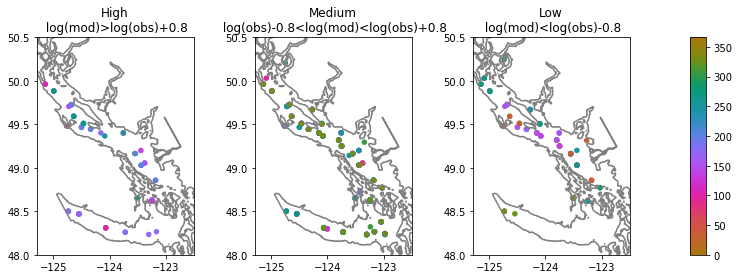

In [53]:
print('Diatoms/DD')
fig,ax=plt.subplots(1,4,figsize=(12,4),gridspec_kw={'width_ratios': [1,1,1,.1],'wspace':.5},)
for iax in ax[0:3]:
    iax.contour(navlon,navlat,tmask[0,:,:],levels=[0.5,],colors='gray')
    iax.set_xlim(-125.3,-122.5)
    iax.set_ylim(48,50.5)
ihi=logt(data['mod_diatoms_chl'])>(logt(data['DD'])+thresh)
ilo=logt(data['mod_diatoms_chl'])<(logt(data['DD'])-thresh)
idata=data.loc[(data.DD>=0)&ihi]
ax[0].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0].set_title('High\n log(mod)>log(obs)+'+str(thresh))
idata=data.loc[(data.DD>=0)&(~ihi)&(~ilo)]
ax[1].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[1].set_title('Medium\n log(obs)-'+str(thresh)+'<log(mod)<log(obs)+'+str(thresh))
idata=data.loc[(data.DD>=0)&ilo]
m=ax[2].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[2].set_title('Low\n log(mod)<log(obs)-'+str(thresh));
fig.colorbar(m,cax=ax[3]);

Flagellates/CCPH


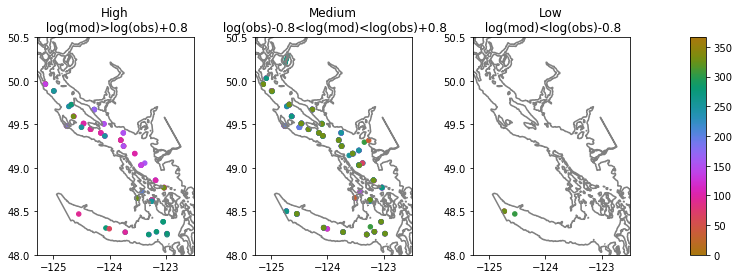

In [54]:
print('Flagellates/CCPH')
fig,ax=plt.subplots(1,4,figsize=(12,4),gridspec_kw={'width_ratios': [1,1,1,.1],'wspace':.5},)
for iax in ax[0:3]:
    iax.contour(navlon,navlat,tmask[0,:,:],levels=[0.5,],colors='gray')
    iax.set_xlim(-125.3,-122.5)
    iax.set_ylim(48,50.5)
ihi=logt(data['mod_flagellates_chl'])>(logt(data['CCPH'])+thresh)
ilo=logt(data['mod_flagellates_chl'])<(logt(data['CCPH'])-thresh)
idata=data.loc[(data.CCPH>=0)&ihi]
ax[0].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0].set_title('High\n log(mod)>log(obs)+'+str(thresh))
idata=data.loc[(data.CCPH>=0)&(~ihi)&(~ilo)]
ax[1].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[1].set_title('Medium\n log(obs)-'+str(thresh)+'<log(mod)<log(obs)+'+str(thresh))
idata=data.loc[(data.CCPH>=0)&ilo]
m=ax[2].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[2].set_title('Low\n log(mod)<log(obs)-'+str(thresh));
fig.colorbar(m,cax=ax[3]);

### Diatom fraction

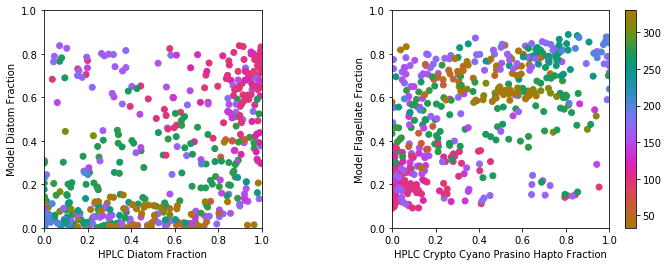

In [55]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
diatFracMod=data['mod_diatoms']/(data['mod_diatoms']+data['mod_flagellates']+data['mod_ciliates'])
diatFracObs=data['DD']/data['TchlA (ug/L)']
m=ax[0].scatter(diatFracObs,diatFracMod,
          c=data['yd'],cmap=cmocean.cm.phase)
ax[0].set_xlabel('HPLC Diatom Fraction')
ax[0].set_ylabel('Model Diatom Fraction')
ax[0].set_xlim((0,1))
ax[0].set_ylim((0,1))
flFracMod=data['mod_flagellates']/(data['mod_diatoms']+data['mod_flagellates']+data['mod_ciliates'])
CCPHFracObs=data['CCPH']/data['TchlA (ug/L)']
m=ax[1].scatter(CCPHFracObs,flFracMod,
          c=data['yd'],cmap=cmocean.cm.phase)
ax[1].set_xlabel('HPLC Crypto Cyano Prasino Hapto Fraction')
ax[1].set_ylabel('Model Flagellate Fraction')
ax[1].set_xlim((0,1))
ax[1].set_ylim((0,1))
ax[0].set_aspect(1)
ax[1].set_aspect(1)

fig.colorbar(m)

In [56]:
#Reminder:
np.random.seed(42)
df = pd.DataFrame(np.random.randn(1000, 4),columns=['a', 'b', 'c','d'])
df['a+b+c']=.2*df['a']+.3*df['b']+.45*df['c']

In [57]:
df.cov()

,a,b,c,d,a+b+c
a,0.929140,0.007946,-0.037053,-0.022301,0.171538
b,0.007946,1.023910,-0.032939,0.004689,0.293940
c,-0.037053,-0.032939,1.012188,0.034186,0.438192
d,-0.022301,0.004689,0.034186,1.013977,0.012330
a+b+c,0.171538,0.293940,0.438192,0.012330,0.319676


In [58]:
df.corr()

,a,b,c,d,a+b+c
a,1.000000,0.008146,-0.038208,-0.022976,0.314749
b,0.008146,1.000000,-0.032355,0.004602,0.513774
c,-0.038208,-0.032355,1.000000,0.033745,0.770334
d,-0.022976,0.004602,0.033745,1.000000,0.021657
a+b+c,0.314749,0.513774,0.770334,0.021657,1.000000


In [59]:
A=np.vstack([df['a'],df['b'],df['c'],df['d'],np.ones(np.shape(df['a']))]).T
b=df['a+b+c']
m=np.linalg.lstsq(A,b,rcond=None)[0]
print(m)

[ 2.00000000e-01  3.00000000e-01  4.50000000e-01  1.59594560e-16
 -1.00613962e-16]
